In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import math

(train, test) , info = tfds.load('cifar10', split =['train', 'test'], 
                                 as_supervised=True , with_info=True)

2022-12-12 16:06:16.450339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:06:16.465851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:06:16.466006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 16:06:16.527426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/home/mortimer/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
    

2022-12-09 16:43:23.220827: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


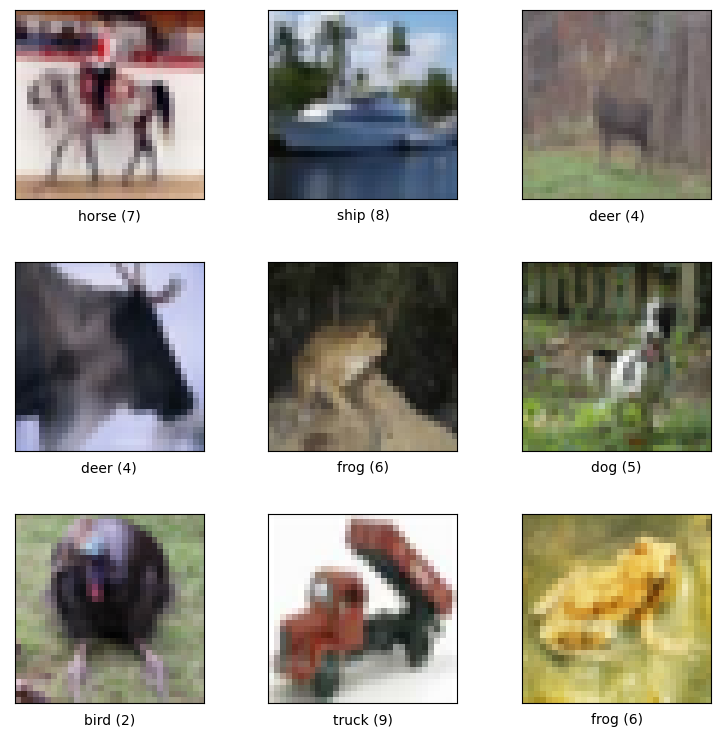

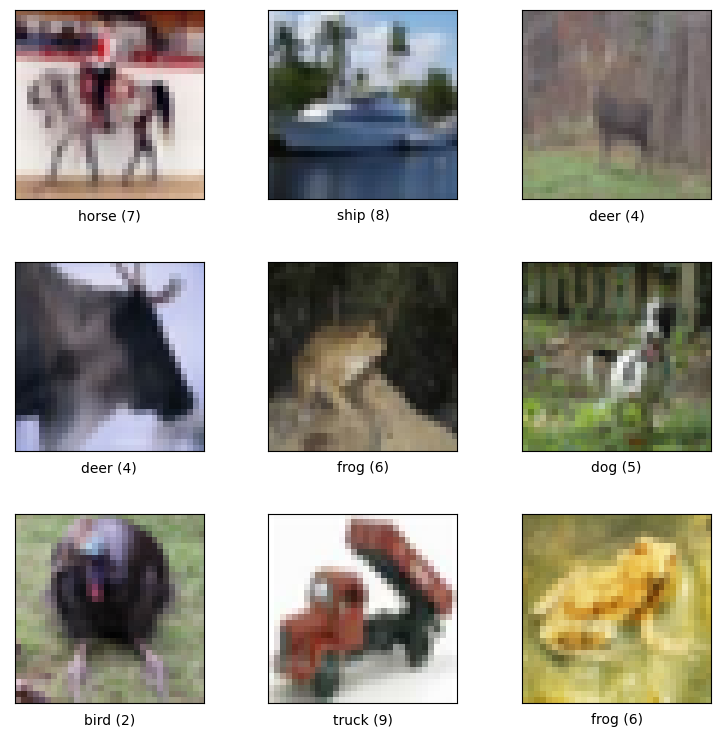

In [2]:
print(info)
tfds.show_examples(train, info)

In [2]:
def coutout(img, length=8, n_holes=4):
    i, j, k = img.shape
    mask = np.ones((i, j, k), dtype=np.float32)
    for n in range(n_holes):
        x = np.random.randint(i)
        y = np.random.randint(j)
        x1 = np.clip(x - length//2, 0, i)
        x2 = np.clip(x + length//2, 0, i)
        y1 = np.clip(y - length//2, 0, j)
        y2 = np.clip(y + length//2, 0, j)
        mask[x1:x2, y1:y2, ...] = 0.
    mask = tf.constant(mask)
    return img * mask



def augment(data):
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target, tf.float32)))
    
    data = data.map(lambda img, target: (tf.keras.layers.RandomCrop(32, 32)(img), target))
    data = data.map(lambda img, target: (coutout(img), target))
    #data = data.map(lambda img, target: (tf.keras.layers.RandomRotation(0.2)(img), target))
    data = data.map(lambda img, target: (tf.keras.layers.RandomFlip(mode="horizontal")(img), target))
    data = data.map(lambda img, target: (tf.keras.layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1))(img), target))
    #data = data.map(lambda img, target: (tf.keras.layers.RandomZoom(0.1)(img), target))
    data = data.map(lambda img, target: (tf.keras.layers.RandomContrast(0.2)(img), target))
    #data = data.map(lambda img, target: (tf.keras.layers.RandomBrightness(0.2)(img), target))
    
    data = data.map(lambda img, target: (tf.cast(img, tf.uint8), tf.cast(target, tf.uint8)))
    return data



def preprocess(data):
    # ONE HOT ENCODING
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # DATA TYPE
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target, tf.float32)))
    # NORMALIZE
    data = data.map(lambda img, target: ((img - 128.)/64., target))
    # DATAFLOW PREP
    data = data.cache()
    data = data.shuffle(1000, seed=42)
    data = data.batch(32)
    data = data.prefetch(20)
    return data


train = train.apply(augment)

2022-12-10 15:35:36.934861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


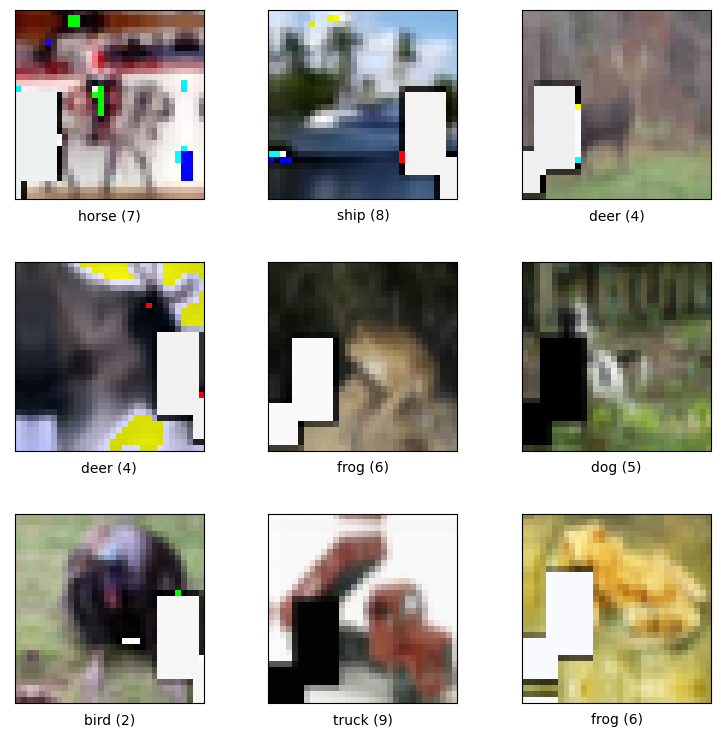

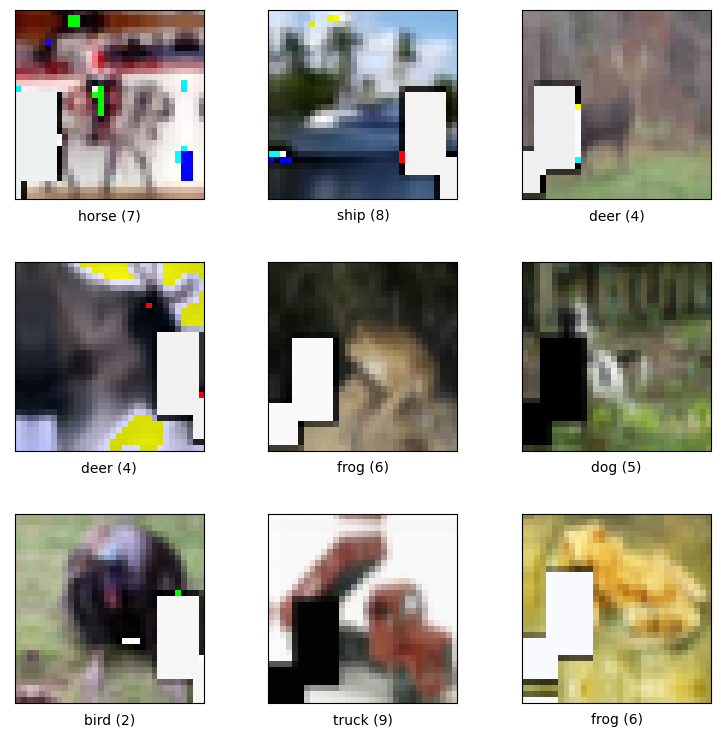

In [94]:
tfds.show_examples(train, info)

In [3]:
train = train.apply(preprocess)
test  = test.apply(preprocess)

In [109]:
from tqdm.notebook import tqdm
import datetime



class ResBlock(tf.keras.layers.Layer):
    L2 = tf.keras.regularizers.L1L2(1e-3, 1e-2)
    def __init__(self, filters, dropout=0.3, pool_size=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = tf.keras.layers.SeparableConv2D(filters=filters, kernel_size=(3, 3), 
                                                      #strides=pool_size, activation=None, 
                                                      kernel_regularizer=self.L2,
                                                      #depthwise_regularizer=self.L2,
                                                      padding='same')
        self.drop_1 = tf.keras.layers.Dropout(dropout)
        self.conv_2 = tf.keras.layers.SeparableConv2D(filters=filters, kernel_size=(3, 3), 
                                                      #strides=pool_size, activation=None, 
                                                      kernel_regularizer=self.L2,
                                                      #depthwise_regularizer=self.L2,
                                                      padding='same')
        self.drop_2 = tf.keras.layers.Dropout(dropout)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    
    
    @tf.function
    def call(self, x, training):
        z = tf.nn.relu(x)
        z = self.conv_1(z, training=training)
        z = self.drop_1(z)
        z = self.conv_1(x, training=training)
        z = tf.nn.relu(z)
        z = self.drop_2(z)
        z = self.conv_2(z, training=training)
        return x + z


class DeepGuck(tf.keras.Model):
    L2 = tf.keras.regularizers.L1L2(1e-3, 1e-2)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                             strides=(1, 1), activation='relu', 
                                             kernel_regularizer=self.L2,
                                             padding='same') # (32, 32) -> (32, 32)
        self.block_1 = ResBlock(128) # (32, 32) -> (32, 32)
        self.block_5 = ResBlock(128) # (32, 32) -> (32, 32)
        self.block_3 = ResBlock(128, pool_size=(2, 2)) # (32, 32) -> (16, 16)
        self.block_6 = ResBlock(128) # (16, 16) -> (16, 16)
        self.block_7 = ResBlock(128) # (16, 16) -> (16, 16)
        self.block_9 = ResBlock(128, pool_size=(2, 2)) # (16, 16) -> (16, 16) -> (8, 8)
        self.conv_2 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3, 3), 
                                                      strides=(2, 2), activation='relu', 
                                                      kernel_regularizer=self.L2,
                                                      depthwise_regularizer=self.L2,
                                                      padding='valid') # (8, 8) -> (3, 3)
        self.pool_4 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))# (3, 3) -> (1, 1)
        self.flatten = tf.keras.layers.Flatten()
        self.affine_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=self.L2)
        self.affine_3 = tf.keras.layers.Dense(10,  activation='softmax', kernel_regularizer=self.L2)
        self.loss = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    
    def setup(self):
        # DEFINE PATHS
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_path = f"logs/{current_time}/train"
        val_log_path = f"logs/{current_time}/val"
        # CONSTRUCT WRITERS
        self.writer_train = tf.summary.create_file_writer(train_log_path)
        self.writer_val   = tf.summary.create_file_writer(val_log_path)
    
    
    @tf.function
    def call(self, x, training=False):
        for layer in self.layers:
            x = layer(x, training=training)
        return x
    
    
    #@tf.function
    def step(self, X, T, training=True):
        if training:
            with tf.GradientTape() as tape:
                Y = self(X, training=training)
                L = self.loss(T, Y)
            gradient = tape.gradient(L, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.trainable_weights))
        else:
            Y = self(X, training)
            L = self.loss(T, Y)
        self.loss_metric.update_state(L)
        self.accuracy_metric.update_state(T, Y)
        return {metric.name: float(metric.result()) for metric in self.metrics}
    
    
    def train(self, train, test, epochs):
        training_metrics = {metric.name: [] for metric in self.metrics}
        testing_metrics = {metric.name: [] for metric in self.metrics}
        self.setup()
        with tqdm(epochs) as bar:
            for epoch in range(epochs):
                # TRAINING
                bar.set_description('TRAINING')
                for X, T  in train:
                    metrics = self.step(X, T, training=True)
                    for name, value in metrics.items():
                        training_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_train.as_default():
                    for metric in model.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=epoch)
                self.reset_metrics()
                # TESTING
                bar.set_description('TESTING')
                for X, T  in test:
                    metrics = self.step(X, T, training=False)
                    for name, value in metrics.items():
                        testing_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_val.as_default():
                    for metric in model.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=epoch)
                self.reset_metrics()
                bar.update(1)
            metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in self.metrics}
            return metrics



model = DeepGuck()
model(np.ones((32, 32, 32, 3)))
model.summary()

Model: "deep_guck_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_333 (Conv2D)         multiple                  3584      
                                                                 
 res_block_21 (ResBlock)     multiple                  35328     
                                                                 
 res_block_22 (ResBlock)     multiple                  35328     
                                                                 
 res_block_23 (ResBlock)     multiple                  35328     
                                                                 
 res_block_24 (ResBlock)     multiple                  35328     
                                                                 
 res_block_25 (ResBlock)     multiple                  35328     
                                                                 
 res_block_26 (ResBlock)     multiple                  

In [4]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [5]:
def smooth(data, level):
    assert level > 1
    data = np.array([data[0]] * (level//2) + data + [data[-1]] * (level//2 - ((level + 1)%2)))
    kernel = np.array([1/level] * level)
    return np.convolve(kernel, data, 'valid')

0it [00:00, ?it/s]

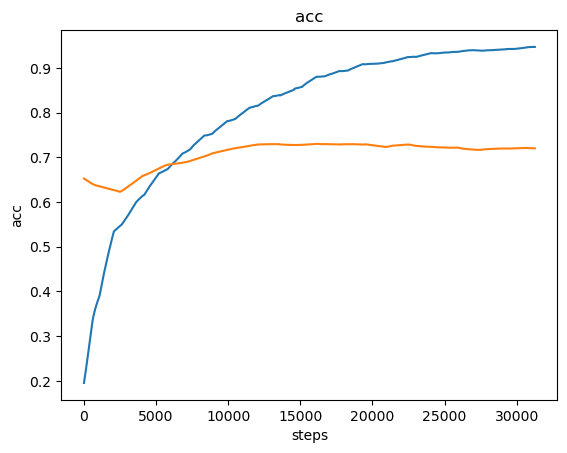

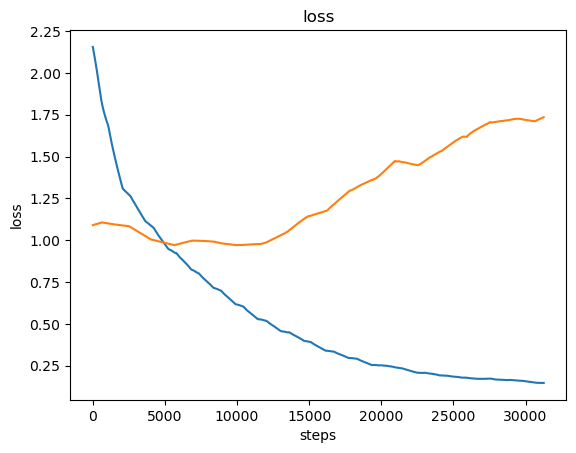

In [110]:
from matplotlib import pyplot as plt
%matplotlib inline


metrics = model.train(train, test, 20)


for name, (train_values, test_values) in metrics.items():
    level = 1000
    plt.title(name)
    plt.xlabel('steps')
    plt.ylabel(name)
    plt.plot(range(len(train_values)), smooth(train_values, level))
    plt.plot(np.arange(len(test_values))/len(test_values) * len(train_values), smooth(test_values, level))
    plt.show()

In [111]:
acc = 0
steps = 100

for i in range(steps):
    X, T = batch = next(iter(test))
    Y = model(X)
    acc += np.mean(np.argmax(Y, axis=1) == np.argmax(T, axis=1))

print(f"{round(acc/steps * 100, 1)}% Accuracy on {steps} steps!")

72.4% Accuracy on 100 steps!


The following class is used as a super class to handle logging and other redundant tasks.

In [6]:
import datetime
from tqdm import tqdm



class Model(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.is_setup = False
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.prev_epochs = 0
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    
    def setup(self):
        if self.is_setup:
            return
        # DEFINE PATHS
        current_time = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
        train_log_path = f"logs/{current_time}/train"
        val_log_path = f"logs/{current_time}/val"
        # CONSTRUCT WRITERS
        self.writer_train = tf.summary.create_file_writer(train_log_path)
        self.writer_val   = tf.summary.create_file_writer(val_log_path)
        self.is_setup = True
    
    
    @tf.function
    def call(self, x, training=False):
        for layer in self.layers:
            x = layer(x, training=training)
        return x
    
    
    @tf.function
    def step(self, X, T, training=True):
        if training:
            with tf.GradientTape() as tape:
                Y = self(X, training=training)
                L = self.loss(T, Y)
            gradient = tape.gradient(L, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.trainable_weights))
        else:
            Y = self(X, training)
            L = self.loss(T, Y)
        self.loss_metric.update_state(L)
        self.accuracy_metric.update_state(T, Y)
        return {metric.name: float(metric.result()) for metric in self.metrics}
    
    
    def train(self, train, test, epochs):
        training_metrics = {metric.name: [] for metric in self.metrics}
        testing_metrics = {metric.name: [] for metric in self.metrics}
        self.setup()
        with tqdm(epochs) as bar:
            for epoch in range(epochs):
                # TRAINING
                bar.set_description('TRAINING')
                for X, T  in train:
                    metrics = self.step(X, T, training=True)
                    for name, value in metrics.items():
                        training_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_train.as_default():
                    for metric in self.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=self.prev_epochs)
                self.reset_metrics()
                # TESTING
                bar.set_description('TESTING')
                for X, T  in test:
                    metrics = self.step(X, T, training=False)
                    for name, value in metrics.items():
                        testing_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_val.as_default():
                    for metric in self.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=self.prev_epochs)
                self.reset_metrics()
                bar.update(1)
                self.prev_epochs += 1
            metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in self.metrics}
            return metrics

The Wide Residuel Network architecture is taken rfom https://arxiv.org/pdf/1605.07146v4.pdf

In [7]:
class WRNBlock(tf.keras.layers.Layer):
    REG = tf.keras.regularizers.L1L2(1e-3, 1e-2)
    def __init__(self, n_filters, strides, skip=False, droprate=0.3, **kwargs):
        super().__init__(**kwargs)
        self.norm_1 = tf.keras.layers.BatchNormalization()
        self.norm_2 = tf.keras.layers.BatchNormalization()
        self.conv_1 = tf.keras.layers.Conv2D(n_filters, 3, padding='same', use_bias=False, 
                                             kernel_regularizer=self.REG, strides=strides)
        self.conv_2 = tf.keras.layers.Conv2D(n_filters, 3, padding='same', use_bias=False,
                                             kernel_regularizer=self.REG)
        self.drop   = tf.keras.layers.Dropout(droprate)
        self.skip   = skip
        if self.skip:
            self.final = tf.keras.layers.Conv2D(n_filters, 1, use_bias=False, strides=strides,
                                                kernel_regularizer=self.REG)
        else:
            self.final = tf.identity
    
    
    @tf.function
    def call(self, x, training=False):
        # UP/DOWN SAMPLING IN THE CASE OF DIFFERENT INPUT AND OUTPUT FILTER NUMBERS 
        if self.skip:
            x = self.norm_1(x, training=training)
            x = tf.nn.relu(x)
            a = self.conv_1(x)
        else:
            a = self.norm_1(x)
            a = tf.nn.relu(a)
            a = self.conv_1(a)
        a = self.norm_2(a, training=training)
        a = tf.nn.relu(a)
        a = self.drop(a, training=training)
        a = self.conv_2(a)
        return a + self.final(x)



class WRNTower(tf.keras.layers.Layer):
    def __init__(self, n_blocks, n_filters, strides, **kwargs):
        super().__init__(**kwargs)
        self.blocks =  [WRNBlock(n_filters, strides,   skip=True)]
        self.blocks += [WRNBlock(n_filters, strides=1, skip=False) for _ in range(n_blocks-1)]
    
    
    @tf.function
    def call(self, x, training=True):
        for block in self.blocks:
            x = block(x, training=training)
        return x



class WRN(Model):
    def __init__(self, depth, width, **kwargs):
        super().__init__(**kwargs)
        n_filters = [16, 16*width, 32*width, 64*width]
        n_blocks  = (depth - 4) // 6
        self.conv = tf.keras.layers.Conv2D(n_filters[0], kernel_size=3, strides=1, padding='same', use_bias=False)
        self.tower_1 = WRNTower(n_blocks, n_filters[1], strides=1)
        self.tower_2 = WRNTower(n_blocks, n_filters[2], strides=2)
        self.tower_3 = WRNTower(n_blocks, n_filters[3], strides=2)
        self.norm    = tf.keras.layers.BatchNormalization()
        self.pool    = tf.keras.layers.AveragePooling2D(pool_size=(8, 8))
        self.flatten = tf.keras.layers.Flatten()
        self.affine  = tf.keras.layers.Dense(10, activation='softmax')
        # OPTIMIZATION
        self.loss = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, decay=5e-4)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, net)
    
    
    @tf.function
    def call(self, x, training=False):
        x = self.conv(x)
        x = self.tower_1(x, training=training)
        x = self.tower_2(x, training=training)
        x = self.tower_3(x, training=training)
        x = self.norm(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.affine(x)
        return x



WideResNet = WRN(28, 10)
print(WideResNet(np.ones((1, 32, 32, 3))))
WideResNet.summary()

2022-12-12 16:07:37.055839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600


tf.Tensor(
[[0.09653808 0.10012794 0.07528456 0.12632959 0.09725264 0.15718465
  0.07082735 0.09754731 0.09860935 0.08029856]], shape=(1, 10), dtype=float32)
Model: "wrn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  432       
                                                                 
 wrn_tower (WRNTower)        multiple                  1642944   
                                                                 
 wrn_tower_1 (WRNTower)      multiple                  6972800   
                                                                 
 wrn_tower_2 (WRNTower)      multiple                  27872000  
                                                                 
 batch_normalization_24 (Bat  multiple                 2560      
 chNormalization)                                                
                                     

In [8]:
metrics = WideResNet.train(train, test, 50)

TESTING: : 50it [3:07:25, 224.90s/it] 


In [9]:
acc = 0
steps = 100
loss = 0

for i in range(steps):
    X, T = batch = next(iter(train))
    Y = WideResNet(X)
    acc += np.mean(np.argmax(Y, axis=1) == np.argmax(T, axis=1))
    loss += tf.keras.losses.CategoricalCrossentropy()(T, Y).numpy()

print(f"TRAINING: {round(acc/steps * 100, 1)}% Accuracy in {steps} steps!")
print(f"TRAINING: {round(loss/steps, 5)} Loss in {steps} steps!")

acc = 0
loss = 0

for i in range(steps):
    X, T = batch = next(iter(test))
    Y = WideResNet(X)
    acc += np.mean(np.argmax(Y, axis=1) == np.argmax(T, axis=1))
    loss += tf.keras.losses.CategoricalCrossentropy()(T, Y).numpy()

print(f"TESTING:  {round(acc/steps * 100, 1)}% Accuracy in {steps} steps!")
print(f"TESTING:  {round(loss/steps, 5)} Loss in {steps} steps!")

TRAINING: 100.0% Accuracy in 100 steps!
TRAINING: 0.00061 Loss in 100 steps!
TESTING:  82.1% Accuracy in 100 steps!
TESTING:  1.10645 Loss in 100 steps!


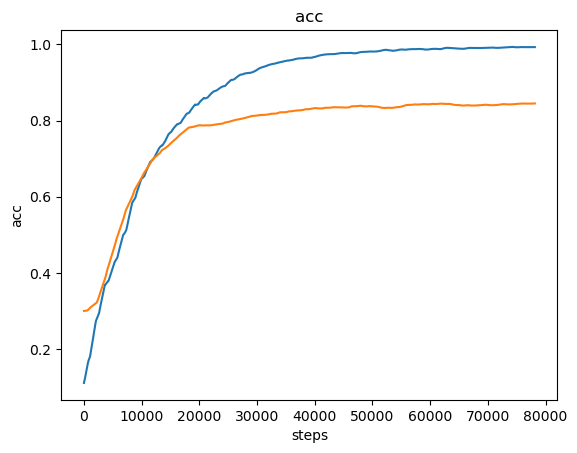

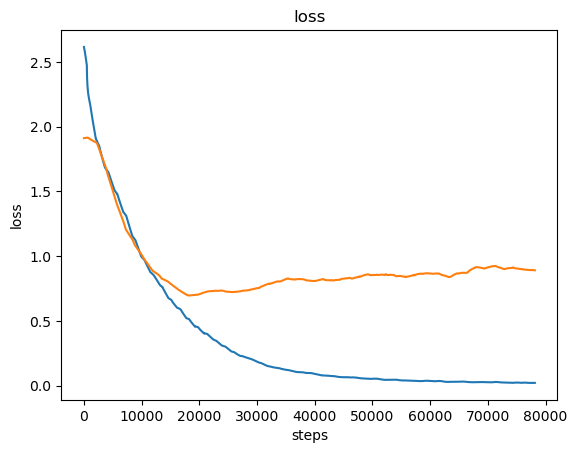

In [100]:
from matplotlib import pyplot as plt
%matplotlib inline



for name, (train_values, test_values) in metrics.items():
    level = 1000
    plt.title(name)
    plt.xlabel('steps')
    plt.ylabel(name)
    plt.plot(range(len(train_values)), smooth(train_values, level))
    plt.plot(np.arange(len(test_values))/len(test_values) * len(train_values), smooth(test_values, level))
    plt.show()

### Optimization techniques:
1. Learning rate decay — Slowly decreases the larning rate to achieve smoother convergence.
2. Regularization — L1 and L2 norms are added to the loss to make the networj sparse (L1) and weights small (L2) to prevent the model of learning the data by heart.
3. Dropout — stochastically set some activations to 0. This makes the model robust to changes in the input and helps it generalizing more easier.
4. Batchnormalization — Normalizes the Batch. Mean and std are learned n training to by applied in prediction.
5. Augmentation:
    5.1. Cutout – removes some random part of the image
    5.2. Flip — flips the image horizontally
    5.3. Translation - moves the image slightly
    5.4. Contrast - applies random contrast to the image
6.ResNetArchitecture — allows for deeper model without vanishing or exploding gradients.